In [36]:
#initialize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.patches as mpatches
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from matplotlib.ticker import MaxNLocator

3. A PAT application

In 2004, the Food and Drug Administration (FDA) released a guidance to encourage innova-
tion in pharmaceutical development, manufacturing and quality assurance. The framework,
called Process Analytical Technology (PAT), combines MultiVariate Data Analysis (MVDA),
Design of Experiments (DoE) and process analytical chemistry methods such as UV, IR, NIR,
NMR (fast, precise, online and preferably non-invasive methods).

Here, we use PCA and PLS, two classic MVDA approaches to assess the feasibility of
using NIR to measure a critical quality component of a wood product, the composition of
wood fiber. In the first part, we will perform unsupervised data exploration with PCA. In
the second part, we will run PLS, a supervised learning algorithm, to quantify the outputs
of interest (i.e. wood composition).

3.1 Description of the process

Sawdust from industrial sawing of birch, pine and spruce is mixed at different ratios to
manufacture a final wood product. The NIR spectra for 15 samples of known composition
of the three different types of wood were used to train the model. Each sample was tested
twice (resulting in 30 rows) and NIR spectra data was collected in the range between 1100-
2300 nm. Thus, the input X-table is (30 rows)x(1201 columns) and the output Y-table
is (30 rows)x(3 columns), where the three outputs/compositions are recorded as percent
proportion of spruce, pine and birch. Data for the training of the model are in the file
sawdust train.xlsx

In order to assess the accuracy of the model developed, we have a test data set of NIR
data (X) and proportions Y different than the training data set. The test data set is not
”seen” by the model during training. The proportions in the test set were selected to be
different than those in the train set to assess the predictive power of the model under realistic
conditions. There were 12 samples measured twice, therefore the number of rows in the X
and Y-tables is 24. The test data are in the file sawdust pred.xlsx
5

In [37]:
#reading training data
saw_train = pd.read_excel('sawdust_train.xlsx')
saw_input = saw_train.iloc[:,2:1203]
saw_output = saw_train.iloc[:,1203:]

3.2.a - Generate the plot of all the training set raw NIR data.

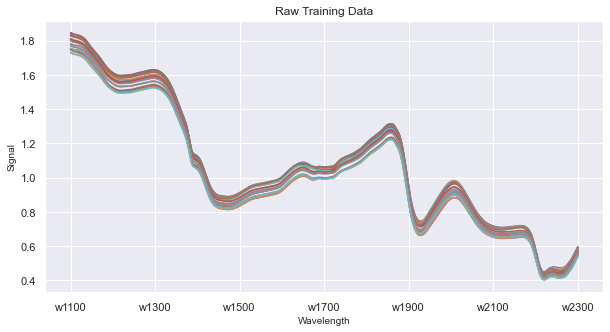

In [38]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,5)})
saw_input.transpose().plot(legend = None)
plt.title('Raw Training Data')
plt.xlabel('Wavelength', fontsize=10)
plt.ylabel('Signal', fontsize=10);
plt.show()

3.2.b - Pre-process the NIR data and perform PCA for 5 components.

In [39]:
#performing PCA on training data for 5 PC's

ss = StandardScaler(with_std = False)
saw_process = ss.fit_transform(saw_input)
pca = PCA(n_components=5, svd_solver='full')
pca_element = pca.fit_transform(saw_process)
scores_pd = pd.DataFrame(data = pca_element,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index = saw_input.index)
s_loading_pd = pd.DataFrame(data = pca.components_.T,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index = saw_input.columns)

3.2.c - Plot the cumulative explained variance versus the number of components. How many
components do we need to capture 99% of the variance?

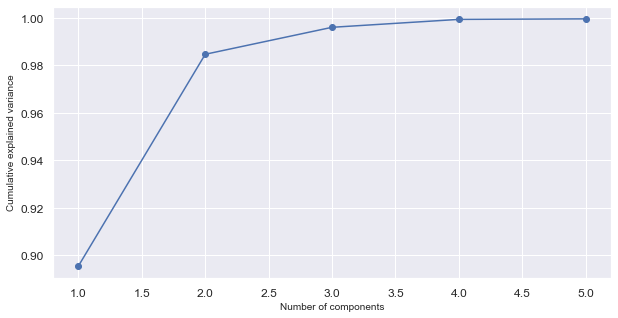

[0.89557845 0.98472379 0.996083   0.99941452 0.99963969]


In [40]:
#plotting the cumulative explained variance
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,5)})

plt.plot(range(1,pca.n_components+1), np.cumsum(pca.explained_variance_ratio_),'-o')
plt.xlabel('Number of components', fontsize=10)
plt.ylabel('Cumulative explained variance', fontsize=10);
plt.tick_params(labelsize=12)
plt.show()
print(cum_exp_var)

3PC's are required to capture 99% of the variance

3.2.d - Plot the PCA scores for the first two components. Comment on any outliers, trends,
clusters etc (if any).

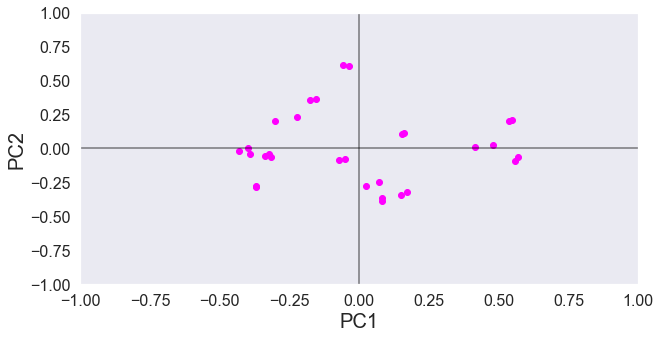

In [41]:
#plotting the scores
# adjusting the scores to fit in (-1,1)
pot_x = pca_element[:,:2]
xt = pot_x[:,0]
yt = pot_x[:,1]
scalext = 1.0/(xt.max() - xt.min())
scaleyt = 1.0/(yt.max() - yt.min())
xt_scaled = xt * scalext
yt_scaled = yt * scaleyt
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,5)})
#plotting scatter plot associated with each location
for (x,y), label in zip(np.vstack((xt_scaled, yt_scaled)).T,scores_pd.index):
    plt.scatter(x, y, color = 'magenta')

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1), fontsize=20)
plt.ylabel("PC{}".format(2), fontsize=20)
plt.tick_params(labelsize=16)
plt.axvline(x=0, c="black", alpha = 0.5)
plt.axhline(y=0, c="black", alpha = 0.5)
plt.grid()

From the scatter plot, there seems to be 3 major clusters. One big cluster with a linear-like trend with increasing PC2 values and PC1 values shifted to the left of the origin and just starting below the x-axis. The second cluster starts below the x-axis and has a downward trend of PC2 as PC1 increases. Lastly, there is a cluster around the x-axis around 0.50 PC1 and the PC2 values are around -0.25 to 0.25. There are two dots around 0.2 PC1 and 0.1 PC2 that do not fit into any of those clusters.

3.2.e - Plot the loadings of the first two components and comment on which wavelengths
seem to be important for different PCs. Don’t describe the graphs in words. In two
sentences, describe any significant trends or signals (if any).

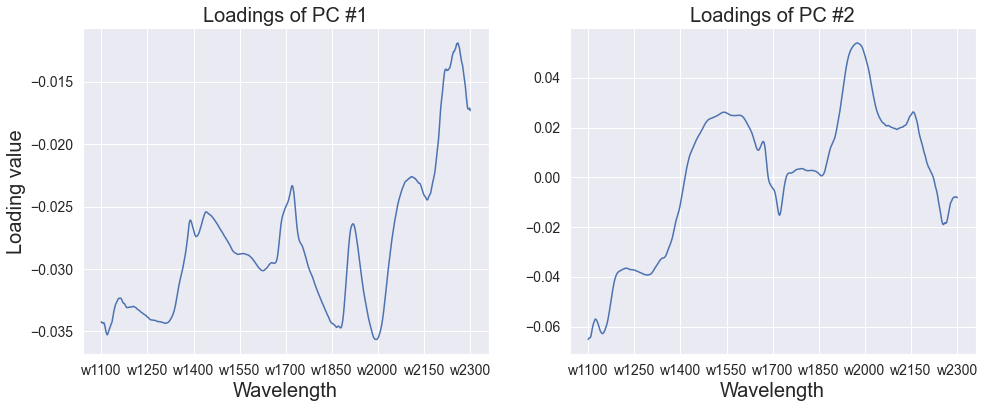

In [42]:
fig0 = plt.figure(figsize=(16, 6))
sub1 = fig0.add_subplot(121)
plt.plot(s_loading_pd['PC1'],'-')
sub1.set_xlabel('Wavelength', fontsize=20)
sub1.set_ylabel('Loading value', fontsize=20)
sub1.set_title('Loadings of PC #1', fontsize=20)
sub1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=14)

sub2 = fig0.add_subplot(122)
plt.plot(s_loading_pd['PC2'],'-')
sub2.set_xlabel('Wavelength', fontsize=20)
sub2.set_title('Loadings of PC #2', fontsize=20)
sub2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=14)

plt.show()

From the PC1 graph, there seems to be a trend that the higher wavelengths will have a smaller negative loading value, such as at w2200, which means more correlation than the lower wavelengths. For PC2, there seems to be a spike at w1550 and w1900 with these being the 2 local maximums in the data signifying possible importance in correlation at these wavelengths

3.2.f - Apply the dimensionality reduction with the PCA model you developed in step B for
the test set using the transform method.

In [43]:
#reading test data
saw_test = pd.read_excel('sawdust_pred.xlsx')
saw_test_input = saw_test.iloc[:,2:1203]
saw_test_output = saw_test.iloc[:,1203:]

In [44]:
#PCA using transform and same PCA solver from training set
ss_saw_test_input = ss.transform(saw_test_input)
pca_element_test = pca.transform(ss_saw_test_input)
st_scores_pd = pd.DataFrame(data = pca_element_test,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index = saw_test_input.index)
st_loading_pd = pd.DataFrame(data = pca.components_.T,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index = saw_test_input.columns)

3.2.g  -Create a scatter plot of the scores in PC1, PC2 of all 54 points in the train and test
data set, coloured by the set they belong to (suggestion: use sns.scatterplot). Why is
it important to overlap the scores of both train and test set in one graph? What are
you checking to see?

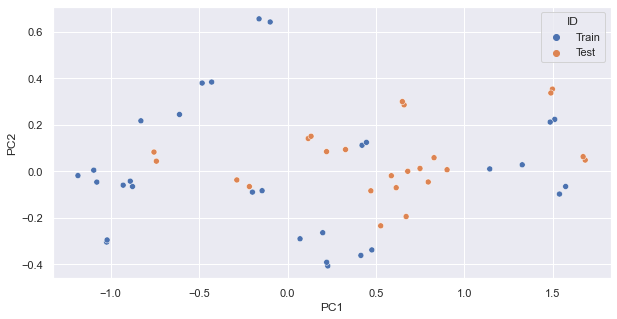

In [45]:
scores_pd['ID'] = 'Train'
st_scores_pd['ID'] = 'Test'

total_score = pd.concat([scores_pd, st_scores_pd], axis = 0)

sns.scatterplot(data = total_score, x = 'PC1', y  ='PC2', hue = 'ID')
plt.show()



It is important to overlap the training and test PCA results in one graph such that we see the testing data describes the test data well for machine learning models. Additionally, since they are both transformed using the same scaled PCA method, this gives an accurate comparsion of datasets. We are checking to see if the clustering from the training data set matches with the clustering that the test data set presents. It is also to check for if the test data is overfitting/underfitting the data.

3.3.a  -Run the PLS regression to model all 3 outputs with the scaled train set spectra.
Increase the number of components to achieve R2 value of at least 0.92 (use PLSRe-
gression’s method score to estimate R2).

In [46]:
saw_train_scaled = pd.DataFrame(saw_process)
saw_test_scaled = pd.DataFrame(pca_element_test)

In [47]:
for iter in range(1,5):
    pls_sklearn = PLSRegression(n_components = iter, scale = False)
    pls_sklearn.fit(saw_process, saw_output)
    score = pls_sklearn.score(saw_process, saw_output)
    if score >= 0.92:
        print(f"The R^2 value is: {round(score,3)} >0.92 for {iter} components")
        break

The R^2 value is: 0.924 >0.92 for 3 components


3.3.b - Predict the output values for the inputs in the test set and compare them by plot-
ting the 24 actual vs predicted values in a 1x3 subplot (for spruce, pine and birch,
respectively). Also, include the y=x line for reference.

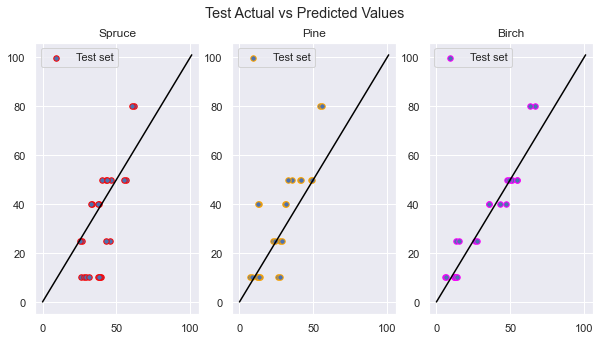

In [48]:
y_test_predict = pls_sklearn.predict(ss_saw_test_input)

f, ax = plt.subplots(1,3)
f.suptitle('Test Actual vs Predicted Values')
sns.set(rc={'figure.figsize':(10,20)})
x = np.linspace(0,101,100)
y = x
#spruce
ax[0].set_title('Spruce')
ax[0].scatter(y_test_predict[:,0], saw_test_output['Spruce'], s=30, marker="o", edgecolors='red')
ax[0].plot(x,y, c= 'black')
ax[0].legend(['Test set'])


#pine
ax[1].set_title('Pine')
ax[1].scatter(y_test_predict[:,1], saw_test_output['Pine'], s=30, marker="o", edgecolors='orange')
ax[1].plot(x,y, c= 'black')
ax[1].legend(['Test set'])

#birchs
ax[2].set_title('Birch')
ax[2].scatter(y_test_predict[:,2], saw_test_output['Birch'], s=30, marker="o", edgecolors='magenta')
ax[2].plot(x,y, c= 'black')
ax[2].legend(['Test set'])

plt.show()